In [1]:
from pathlib import Path

src = Path().resolve().parent / 'src'

# Dataset with Scientific Papers

In [2]:
import pandas as pd
from src.config import PAPER_DATASET_PATH, PREPROCESSED_PAPER_DATASET_PATH

papers = pd.read_csv(PAPER_DATASET_PATH)
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  9680 non-null   int64 
 1   year       9680 non-null   int64 
 2   title      9680 non-null   object
 3   abstract   6361 non-null   object
 4   full_text  9677 non-null   object
dtypes: int64(2), object(3)
memory usage: 378.3+ KB


In [3]:
characters_per_page = 2700
min_page_number = 20

papers = papers[papers["abstract"].notna() & (papers["abstract"].str.strip() != "") &
                papers["full_text"].notna() & (papers["full_text"].str.strip() != "")]
papers.loc[:, "full_text_size"] = papers["full_text"].astype(str).apply(len)
papers = papers[(papers["full_text_size"] >= characters_per_page * min_page_number)]
papers.sort_values(by=["full_text_size", "year"], ascending=[True, False], inplace=True)
papers = papers.reset_index(drop=True)
papers = papers.drop(columns=["source_id", "year"])

In [4]:
papers

,title,abstract,full_text,full_text_size
0,Learning towards Minimum Hyperspherical Energy,Neural networks are a powerful class of nonlin...,Learning towards Minimum Hyperspherical Energy...,54155
1,Time-series Generative Adversarial Networks,A good generative model for time-series data s...,Time-series Generative Adversarial Networks\n\...,54208
2,Pipe-SGD: A Decentralized Pipelined SGD Framew...,Distributed training of deep nets is an import...,Pipe-SGD: A Decentralized Pipelined SGD\n\nFra...,54292
3,Integrated accounts of behavioral and neuroima...,Neuroscience studies of human decision-making ...,Integrated accounts of behavioral and neuroima...,54542
4,Learning Pipelines with Limited Data and Domai...,As machine learning becomes more widely used i...,Learning Pipelines with Limited Data and Domai...,54687
...,...,...,...,...
70,Learning Multiagent Communication with Backpro...,Many tasks in AI require the collaboration of ...,Learning Multiagent Communication\n\nwith Back...,122727
71,Abstraction based Output Range Analysis for Ne...,"In this paper, we consider the problem of outp...",Abstraction based Output Range Analysis for Ne...,140078
72,Poisson-Randomized Gamma Dynamical Systems,This paper presents the Poisson-randomized gam...,Poisson-Randomized Gamma Dynamical Systems\n\n...,143151
73,Semi-supervisedly Co-embedding Attributed Netw...,Deep generative models (DGMs) have achieved re...,Semi-supervisedly Co-embedding Attributed\n\nN...,163416


In [5]:
papers.to_csv(PREPROCESSED_PAPER_DATASET_PATH, index=False)

# Dataset with Blogs

In [6]:
from src.config import BLOG_DATASET_PATH, PREPROCESSED_BLOG_DATASET_PATH

# Import data
blogs = pd.read_csv(BLOG_DATASET_PATH)

# Correcting URL of the paper if needed
blogs["url_paper"] = blogs["url_paper"].str.replace("abs", "pdf", regex=False)

# Calculate engagement score
blogs["engagement_score"] = (blogs["claps"] + 3 * blogs["comments"]) / blogs["author_followers"]
min_val = blogs["engagement_score"].min()
max_val = blogs["engagement_score"].nlargest(3).iloc[-1] # Ignore 2 outliers
blogs["normalized_engagement_score"] = 100 * (blogs["engagement_score"] - min_val) / (max_val - min_val) # Experimental MinMax normalization
blogs["normalized_engagement_score"] = round(blogs["normalized_engagement_score"].clip(1, 100), 1)

In [7]:
blogs

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score,normalized_engagement_score
0,1,Training Large Language Models: From TRPO to GRPO,https://medium.com/data-science-collective/tra...,Maxime Wolf,349,177,1,Foundations of Large Language Models,https://arxiv.org/pdf/2501.09223,0.515759,49.7
1,2,Training Large Language Models: From TRPO to GRPO,https://medium.com/data-science-collective/tra...,Maxime Wolf,349,177,1,DeepSeek-R1: Incentivizing Reasoning Capabilit...,https://arxiv.org/pdf/2501.12948,0.515759,49.7
2,3,Training Large Language Models: From TRPO to GRPO,https://medium.com/data-science-collective/tra...,Maxime Wolf,349,177,1,DeepSeekMath: Pushing the Limits of Mathematic...,https://arxiv.org/pdf/2402.03300,0.515759,49.7
3,4,Training Large Language Models: From TRPO to GRPO,https://medium.com/data-science-collective/tra...,Maxime Wolf,349,177,1,Trust Region Policy Optimization,https://arxiv.org/pdf/1502.05477,0.515759,49.7
4,5,What is the System 2 LLM or AI Chatbot?,https://medium.com/@don-lim/what-is-the-system...,Don Lim,413,17,0,Guiding Language Model Reasoning with Planning...,https://arxiv.org/pdf/2310.05707,0.041162,4.0
5,6,What is the System 2 LLM or AI Chatbot?,https://medium.com/@don-lim/what-is-the-system...,Don Lim,413,17,0,Distilling System 2 into System 1,https://arxiv.org/pdf/2407.06023,0.041162,4.0
6,7,What is the System 2 LLM or AI Chatbot?,https://medium.com/@don-lim/what-is-the-system...,Don Lim,413,17,0,Chain-of-Thought Prompting Elicits Reasoning i...,https://arxiv.org/pdf/2201.11903,0.041162,4.0
7,8,What is the System 2 LLM or AI Chatbot?,https://medium.com/@don-lim/what-is-the-system...,Don Lim,413,17,0,Tree of Thoughts: Deliberate Problem Solving w...,https://arxiv.org/pdf/2305.10601,0.041162,4.0
8,9,What is the System 2 LLM or AI Chatbot?,https://medium.com/@don-lim/what-is-the-system...,Don Lim,413,17,0,Branch-Solve-Merge Improves Large Language Mod...,https://arxiv.org/pdf/2310.15123,0.041162,4.0
9,10,What is the System 2 LLM or AI Chatbot?,https://medium.com/@don-lim/what-is-the-system...,Don Lim,413,17,0,System 2 Attention (is something you might nee...,https://arxiv.org/pdf/2311.11829,0.041162,4.0


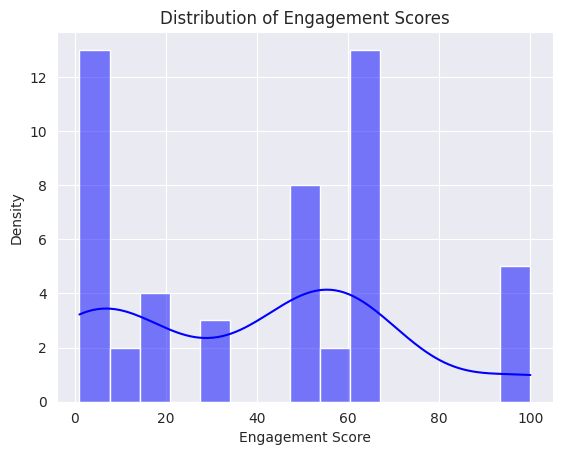

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(blogs["normalized_engagement_score"], bins=15, kde=True, color="blue")
plt.xlabel("Engagement Score")
plt.ylabel("Density")
plt.title("Distribution of Engagement Scores")
plt.show()

In [9]:
def classify_blog(score):
    """Return blog classification based on engagement score."""
    if score >= 80:
        return "Excellent"
    elif score >= 60:
        return "Very Good"
    elif score >= 40:
        return "Good"
    elif score >= 20:
        return "Average"
    else:
        return "Bad"

blogs["engagement_level"] = blogs["normalized_engagement_score"].apply(classify_blog)
order = ["Bad", "Average", "Good", "Very Good", "Excellent"]
blogs["engagement_level"] = pd.Categorical(blogs["engagement_level"], categories=order, ordered=True)

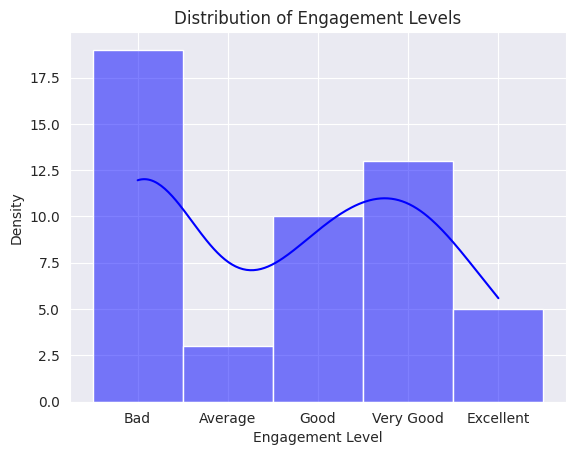

In [10]:
sns.histplot(blogs["engagement_level"], bins=5, kde=True, color="blue")
plt.xlabel("Engagement Level")
plt.ylabel("Density")
plt.title("Distribution of Engagement Levels")
plt.show()

In [11]:
blogs.to_csv(PREPROCESSED_BLOG_DATASET_PATH, index=False)